In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.3f' % x)

DATA_PATH = "../data/raw/dataset.csv"

data = pd.read_csv(DATA_PATH).iloc[:, 1:] # exclude the first column as it is the index
data[:5]

,gene_id,transcript_id,transcript_position,k_mer,left_dwell,left_std,left_mean,mid_dwell,mid_std,mid_mean,right_dwell,right_std,right_mean,label,D1,D2,R,H1,H2
0,ENSG00000004059,ENST00000000233,244,AAGACCA,0.003,2.060,125.000,0.018,10.400,122.000,0.009,10.900,84.100,0,1,0,0,0,1
1,ENSG00000004059,ENST00000000233,244,AAGACCA,0.006,2.530,125.000,0.008,4.670,126.000,0.010,6.300,80.900,0,1,0,0,0,1
2,ENSG00000004059,ENST00000000233,244,AAGACCA,0.005,3.920,109.000,0.014,12.000,124.000,0.005,2.130,79.600,0,1,0,0,0,1
3,ENSG00000004059,ENST00000000233,244,AAGACCA,0.004,2.060,125.000,0.008,5.010,130.000,0.005,3.780,80.400,0,1,0,0,0,1
4,ENSG00000004059,ENST00000000233,244,AAGACCA,0.007,2.920,120.000,0.003,3.940,129.000,0.013,7.150,82.200,0,1,0,0,0,1


In [2]:
# Selecting specific columns
selected_columns = [
    "gene_id", 'left_dwell', 'left_std', 'left_mean',
    'mid_dwell', 'mid_std', 'mid_mean',
    'right_dwell', 'right_std', 'right_mean', 'label'
]
result_df = data[selected_columns]

print(result_df[:5])

           gene_id  left_dwell  left_std  left_mean  mid_dwell  mid_std  \
0  ENSG00000004059       0.003     2.060    125.000      0.018   10.400   
1  ENSG00000004059       0.006     2.530    125.000      0.008    4.670   
2  ENSG00000004059       0.005     3.920    109.000      0.014   12.000   
3  ENSG00000004059       0.004     2.060    125.000      0.008    5.010   
4  ENSG00000004059       0.007     2.920    120.000      0.003    3.940   

   mid_mean  right_dwell  right_std  right_mean  label  
0   122.000        0.009     10.900      84.100      0  
1   126.000        0.010      6.300      80.900      0  
2   124.000        0.005      2.130      79.600      0  
3   130.000        0.005      3.780      80.400      0  
4   129.000        0.013      7.150      82.200      0  


Attempt 1

In [ ]:
import tensorflow
import keras
from keras import layers
import numpy as np

# Define the size of your encoded representations
encoding_dim = 32  # Adjust as needed

# Load and preprocess your dataset
# Replace this with your dataset loading and preprocessing code
# Make sure you have 'x_data' as your input features and 'y_labels' as your labels

# Filter your data to keep only label 0
# x_data_label_0 = x_data[y_labels == 0]
x_data_label_0 = result_df[result_df['label'] == 0].drop(columns=['label'])

# Define the input shape based on your feature dimensionality
input_shape = (9,)  # Adjust to match your data

# Create the input layer
input_img = keras.Input(shape=input_shape)

# Define the architecture of the autoencoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_shape[0], activation='sigmoid')(encoded)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create the encoder model
encoder = keras.Model(input_img, encoded)

# Create the decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using only the samples with label 0
autoencoder.fit(x_data_label_0, x_data_label_0,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)  # You can use a validation split

# Encode and decode the data
encoded_data = encoder.predict(result_df)  # Encode all data
decoded_data = decoder.predict(encoded_data)

# Calculate the similarity between original and reconstructed data
# You can use a suitable similarity metric (e.g., mean squared error)
similarity = np.mean(np.square(result_df - decoded_data), axis=1)

# Set a similarity threshold (you can adjust this value)
threshold = 0.1

# Assign labels based on the similarity threshold
predicted_labels = [1 if sim > threshold else 0 for sim in similarity]


Attempt 2

In [ ]:
import tensorflow
import keras
from keras import layers
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define the size of your encoded representations
encoding_dim = 3  # Adjust as needed

# Filter your data to keep only label 0
x_data_label_0 = result_df[result_df['label'] == 0].drop(columns=['label'])

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform
x_data_label_0_scaled = scaler.fit_transform(x_data_label_0)

# Define the input shape based on your feature dimensionality
input_shape = (x_data_label_0_scaled.shape[1],)  # This will be (9,)

# Create the input layer
input_img = keras.Input(shape=input_shape)

# Define the architecture of the autoencoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_shape[0], activation='sigmoid')(encoded)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create the encoder model
encoder = keras.Model(input_img, encoded)

# Create the decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using the scaled data
autoencoder.fit(x_data_label_0_scaled, x_data_label_0_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)  # You can use a validation split

# To encode and decode, make sure to scale the input data first
result_df_scaled = scaler.transform(result_df.drop(columns=['label']))

# Encode and decode the scaled data
encoded_data = encoder.predict(result_df_scaled)
decoded_data = decoder.predict(encoded_data)

# You might want to inverse transform the decoded data if you're going to calculate similarity with original data
decoded_data_inverse_transformed = scaler.inverse_transform(decoded_data)

# Calculate the similarity between original and reconstructed data
similarity = np.mean(np.square(result_df.drop(columns=['label']) - decoded_data_inverse_transformed), axis=1)

# Set a similarity threshold (you can adjust this value)
threshold = 0.1

# Assign labels based on the similarity threshold
predicted_labels = [1 if sim > threshold else 0 for sim in similarity]


Attempt 3

In [27]:
import tensorflow
import keras
from keras import layers
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define the size of your encoded representations
encoding_dim = 3  # Adjust as needed

# Filter your data to keep only label 0
x_data_label_0 = result_df[result_df['label'] == 0].drop(columns=['label'])

# Get unique gene_id values
unique_genes = result_df['gene_id'].unique()

# Shuffle the unique gene_ids
np.random.shuffle(unique_genes)

# Split unique gene_ids into train, validation, and test
train_size = int(0.6 * len(unique_genes))
val_size = int(0.2 * len(unique_genes))
train_genes = unique_genes[:train_size]
val_genes = unique_genes[train_size:train_size + val_size]
test_genes = unique_genes[train_size + val_size:]

# Create train, validation, and test dataframes based on the split gene_ids
train_df = x_data_label_0[x_data_label_0['gene_id'].isin(train_genes)]
val_df = x_data_label_0[x_data_label_0['gene_id'].isin(val_genes)]
test_df = x_data_label_0[x_data_label_0['gene_id'].isin(test_genes)]

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Exclude gene_id for scaling
features_to_scale = train_df.drop(columns=['gene_id'])

# Fit the scaler to the training data and transform
train_df_scaled = scaler.fit_transform(features_to_scale)

# For the validation set, also exclude gene_id before scaling
val_features_to_scale = val_df.drop(columns=['gene_id'])
val_df_scaled = scaler.transform(val_features_to_scale)

# Define the input shape based on your feature dimensionality
input_shape = (train_df_scaled.shape[1],)  # This will be (10,)

# Create the input layer
input_img = keras.Input(shape=input_shape)

# Define the architecture of the autoencoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_shape[0], activation='sigmoid')(encoded)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create the encoder model
encoder = keras.Model(input_img, encoded)

# Create the decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using the scaled data
autoencoder.fit(train_df_scaled, train_df_scaled,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(val_df_scaled, val_df_scaled))

# To encode and decode, use the test set
test_features_to_scale = test_df.drop(columns=['gene_id'])
test_df_scaled = scaler.transform(test_features_to_scale)


# Encode and decode the scaled test data
encoded_data = encoder.predict(test_df_scaled)
decoded_data = decoder.predict(encoded_data)

# You might want to inverse transform the decoded data if you're going to calculate similarity with original data
decoded_data_inverse_transformed = scaler.inverse_transform(decoded_data)

# Calculate the similarity between original and reconstructed test data
similarity = np.mean(np.square(test_features_to_scale - decoded_data_inverse_transformed), axis=1)

Epoch 1/5
24400/24400 [==============================] - 58s 2ms/step - loss: 0.3151 - val_loss: 0.3096
Epoch 2/5
24400/24400 [==============================] - 55s 2ms/step - loss: 0.3091 - val_loss: 0.3096
Epoch 3/5
24400/24400 [==============================] - 57s 2ms/step - loss: 0.3091 - val_loss: 0.3096
Epoch 4/5
24400/24400 [==============================] - 57s 2ms/step - loss: 0.3091 - val_loss: 0.3096
Epoch 5/5
63212/63212 [==============================] - 79s 1ms/step


In [3]:
import tensorflow
import keras
from keras import layers
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define the size of your encoded representations
encoding_dim = 3  # Adjust as needed

# Filter your data to keep only label 0
x_data_label_0 = result_df[result_df['label'] == 0].drop(columns=['label'])

# Get unique gene_id values
unique_genes = result_df['gene_id'].unique()

# Shuffle the unique gene_ids
np.random.shuffle(unique_genes)

# Split unique gene_ids into train, validation, and test
train_size = int(0.6 * len(unique_genes))
val_size = int(0.2 * len(unique_genes))
train_genes = unique_genes[:train_size]
val_genes = unique_genes[train_size:train_size + val_size]
test_genes = unique_genes[train_size + val_size:]

# Create train, validation, and test dataframes based on the split gene_ids
train_df = x_data_label_0[x_data_label_0['gene_id'].isin(train_genes)]
val_df = x_data_label_0[x_data_label_0['gene_id'].isin(val_genes)]
test_df = x_data_label_0[x_data_label_0['gene_id'].isin(test_genes)]

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Exclude gene_id for scaling
features_to_scale = train_df.drop(columns=['gene_id'])

# Fit the scaler to the training data and transform
train_df_scaled = scaler.fit_transform(features_to_scale)

# For the validation set, also exclude gene_id before scaling
val_features_to_scale = val_df.drop(columns=['gene_id'])
val_df_scaled = scaler.transform(val_features_to_scale)

# Define the input shape based on your feature dimensionality
input_shape = (train_df_scaled.shape[1],)  # This will depend on your data

# Create the input layer
input_img = keras.Input(shape=input_shape)

# Define the architecture of the autoencoder
# First hidden layer
hidden1_size = 64  # Hyperparameter: number of neurons in the first hidden layer
hidden1 = layers.Dense(hidden1_size, activation='relu')(input_img)

# Second hidden layer (encoded layer)
# You can adjust 'encoding_dim' as a hyperparameter to fine-tune the size of the bottleneck layer
encoded = layers.Dense(encoding_dim, activation='relu')(hidden1)

# Third hidden layer (decoder starts here)
hidden2_size = hidden1_size  # You can set this to another value if desired
hidden2 = layers.Dense(hidden2_size, activation='relu')(encoded)

# Output layer
decoded = layers.Dense(input_shape[0], activation='sigmoid')(hidden2)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create the encoder model
encoder = keras.Model(input_img, encoded)

# Create the decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layers = autoencoder.layers[-2](encoded_input)  # Use third hidden layer
decoder_output = autoencoder.layers[-1](decoder_layers)  # Use output layer
decoder = keras.Model(encoded_input, decoder_output)

# Hyperparameters: You can adjust the optimizer type, learning rate, and loss function as needed
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using the scaled data
# Hyperparameters: You can adjust the number of epochs and batch size
autoencoder.fit(train_df_scaled, train_df_scaled,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(val_df_scaled, val_df_scaled))

# To encode and decode, use the test set
test_features_to_scale = test_df.drop(columns=['gene_id'])
test_df_scaled = scaler.transform(test_features_to_scale)


# Encode and decode the scaled test data
encoded_data = encoder.predict(test_df_scaled)
decoded_data = decoder.predict(encoded_data)

# You might want to inverse transform the decoded data if you're going to calculate similarity with original data
decoded_data_inverse_transformed = scaler.inverse_transform(decoded_data)

# Calculate the similarity between original and reconstructed test data
similarity = np.mean(np.square(test_features_to_scale - decoded_data_inverse_transformed), axis=1)

Epoch 1/5
25025/25025 [==============================] - 94s 4ms/step - loss: 0.3197 - val_loss: 0.3155
Epoch 2/5
25025/25025 [==============================] - 79s 3ms/step - loss: 0.3145 - val_loss: 0.3142
Epoch 3/5
25025/25025 [==============================] - 113s 5ms/step - loss: 0.3129 - val_loss: 0.3122
Epoch 4/5
25025/25025 [==============================] - 93s 4ms/step - loss: 0.3116 - val_loss: 0.3119
Epoch 5/5
65878/65878 [==============================] - 98s 1ms/step


In [4]:
similarity

40416      12.798
40417       2.828
40418       3.194
40419       1.338
40420       1.817
            ...  
11018356    1.064
11018357    3.763
11018358    6.559
11018359    0.298
11018360    0.502
Length: 2108084, dtype: float64

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Your similarity data (as a list or numpy array for this example)

# Reshape the similarity data
similarity_reshaped = [[value] for value in similarity]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the similarity values
normalized_similarity = scaler.fit_transform(similarity_reshaped)

# Flatten the normalized similarity data back to a 1D list
normalized_similarity = [value[0] for value in normalized_similarity]


In [6]:
import numpy as np

# Calculate the 95th percentile
percentile_5 = np.percentile(normalized_similarity, 5)

print(percentile_5)


6.606773176661034e-05


In [7]:
# Set a similarity threshold (you can adjust this value)
threshold = percentile_5

# Assign labels based on the similarity threshold
predicted_labels = [0 if sim > threshold else 1 for sim in normalized_similarity]

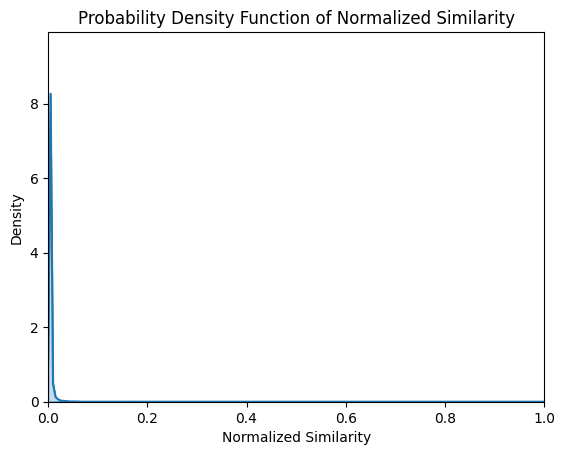

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the PDF
sns.kdeplot(normalized_similarity, fill=True)

# Adjust x and y axis limits to focus on the bulk of the data
plt.xlim(min(normalized_similarity), max(normalized_similarity))
plt.ylim(0, 1.2 * max(sns.kdeplot(normalized_similarity, cumulative=False).get_lines()[0].get_data()[1]))

plt.xlabel('Normalized Similarity')
plt.ylabel('Density')
plt.title('Probability Density Function of Normalized Similarity')
plt.show()


In [9]:
sum(predicted_labels)

105405

In [10]:
count_label_1 = result_df[result_df['label'] == 1].shape[0]
print(count_label_1)


499574
